In [1]:
import numpy as np
# import igraph
from scipy import sparse
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from bluepysnap import Circuit
# import matplotlib.patches as mpatches
from scipy.sparse import csc_matrix
import tqdm
import os

In [2]:
from graph_analysis.randomize import DistanceDependentConfigurationalModel
from graph_analysis.rich_cub import RichClubAnalysis
# from graph_analysis.randomize import ErdosRenyiModel

In [3]:
dpi=300
file_format = 'png'
fig_save_dir = f'{os.getcwd()}/output/'

In [4]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'
synaptome = sparse.load_npz(adj_path)
connectome = synaptome.copy()
connectome[connectome > 0] = 1

In [5]:
target = 'slice10'

CIRCUIT_DIR =  '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json'
circuit = Circuit(CIRCUIT_DIR)
nodes = circuit.nodes["hippocampus_neurons"]
edges = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical_synapse"]
target_indices = nodes.ids(target)

target_synaptome = synaptome[target_indices,:][:,target_indices]
# mtypes_by_gid = c.nodes['hippocampus_neurons'].get().mtype.values

xyz = nodes.get(target)[['x','y','z']]

In [6]:
target_connectome = target_synaptome.copy()
target_connectome[target_connectome>1]=1

In [7]:
indegrees = target_connectome.sum(axis=0)

In [8]:
model = DistanceDependentConfigurationalModel(target_connectome,xyz)
dd_adj = model.generate()

12615it [00:05, 2138.09it/s]


In [9]:
rca = RichClubAnalysis(target_connectome)

In [10]:
import dask
import dask.bag as db
from dask.distributed import Client

In [11]:
dd_adj = sparse.load_npz('../output/random_models/dd_configurational_slice10.npz')
indegrees_dd = dd_adj.sum(axis=0).A.flatten()
outdegrees_dd = dd_adj.sum(axis=1).A.flatten()
rca_dd = RichClubAnalysis(dd_adj.astype(int))

In [10]:
# num_syns_per_conn = target_synaptome.sum() / target_synaptome.count_nonzero()
# num_syns_per_conn = np.round(num_syns_per_conn).astype(int)

In [11]:
# dd_synaptme = dd_adj.copy().astype(int)
# dd_synaptme *= num_syns_per_conn

In [ ]:
# model_outdegree = model.to_connectome(model.synaptome).sum(axis=1).flatten()
# dd_outdegree = dd_adj.sum(axis=1).flatten()
# np.testing.assert_array_equal(model_outdegree,dd_outdegree)

# # save adjacency matrix
# sparse.save_npz(f'{save_dir}/dd_configurational_{target}.npz',dd_adj)

In [14]:
import networkx as nx

In [15]:
num_nodes = target_synaptome.shape[1]
conn_prob = target_synaptome.count_nonzero() / (target_synaptome.shape[0] * (target_synaptome.shape[0]-1))

In [17]:
target_er = nx.erdos_renyi_graph(num_nodes,conn_prob,seed=10,directed=True)
adj_er = nx.adjacency_matrix(target_er)
rca_er = RichClubAnalysis(adj_er)
indegree_er = adj_er.sum(axis=0)

In [18]:
# in or outdegree alone is not graphical so degree preserving randomization is not feasable
# but total degree is
dg = connectome.sum(axis=1).A.flatten() + connectome.sum(axis=0).A.flatten()
nx.is_graphical(dg)

True

In [20]:
from graph_analysis.randomize import DegreePreservingConnectomeModel


In [23]:
connectome_dp_model = DegreePreservingConnectomeModel(target_connectome)

In [29]:
rand_connectome_dp = connectome_dp_model.generate()
rca_dp = RichClubAnalysis(rand_connectome_dp)

In [26]:
M_synaptome = target_synaptome.tocoo()
M_synaptome.col = np.random.permutation(M_synaptome.col)
np.testing.assert_array_almost_equal(M_synaptome.sum(axis=0).A.flatten(),
                                     target_synaptome.sum(axis=0).A.flatten())

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 12599 / 12615 (99.9%)
Max absolute difference: 4136.
Max relative difference: 2.83333333
 x: array([  29.,    6.,   41., ...,  926., 2327., 2774.])
 y: array([  41.,   15.,   35., ..., 1059., 3345., 3537.])

In [27]:
np.testing.assert_array_almost_equal(target_connectome.tocoo().col,target_synaptome.tocoo().col)

In [121]:
M.sum(axis=1).A.flatten().max() 

27213.0

In [122]:
target_connectome.sum(axis=1).A.flatten().max() 

3732.0

In [48]:
# Example usage

# Start Dask client
client = Client()

k_dict_parallel_model = rca.calculate_rich_club_coefficients(indegrees)
k_dict_parallel_dd = rca_dd.calculate_rich_club_coefficients(indegrees_dd)
k_dict_parallel_er = rca_er.calculate_rich_club_coefficients(indegree_er)

# Shutdown the Dask client
client.shutdown()


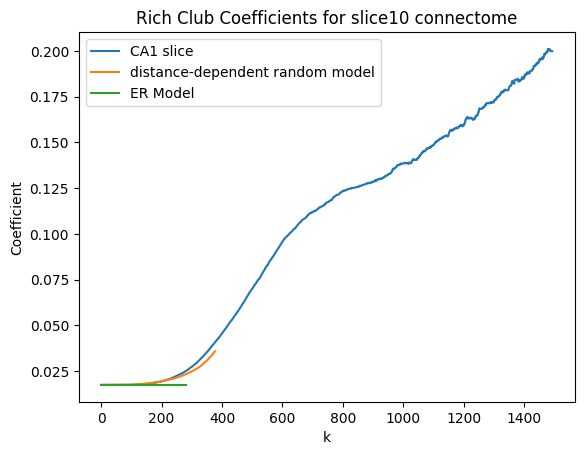

In [50]:
plt.plot(k_dict_parallel_model.keys(),k_dict_parallel_model.values())
plt.plot(k_dict_parallel_dd.keys(),k_dict_parallel_dd.values())
plt.plot(k_dict_parallel_er.keys(),k_dict_parallel_er.values())

plt.title('Rich Club Coefficients for slice10 connectome')
plt.xlabel('k')
plt.ylabel('Coefficient')
plt.legend(['CA1 slice','distance-dependent random model','ER Model'])
plt.savefig(f"../output/rich_club_directed_indegree.png", dpi=dpi, bbox_inches='tight')

In [230]:
# rand_connectome_dp = degree_preserve_randomize(target_connectome)
# rca_dp = RichClubAnalysis(rand_connectome_dp.tocsc())

<__array_function__ internals>:200: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.


In [30]:
outdegrees_conn = target_connectome.sum(axis=1).A.flatten().astype(int)
outdegrees_er = adj_er.sum(axis=1)
outdegrees_dd = dd_adj.sum(axis=1).A.flatten()
outdegrees_dp = rand_connectome_dp.sum(axis=1).A.flatten().astype(int)

indegrees_conn = target_connectome.sum(axis=0).A.flatten().astype(int)
indegrees_er = adj_er.sum(axis=0)
indegrees_dd = dd_adj.sum(axis=0).A.flatten()
indegrees_dp = rand_connectome_dp.sum(axis=0).A.flatten().astype(int)

tot_degrees_conn = indegrees_conn + outdegrees_conn
tot_degrees_er = indegree_er + outdegrees_er
tot_degrees_dd = indegrees_dd + outdegrees_dd
tot_degrees_dp = indegrees_dp + outdegrees_dp

In [31]:
outdegrees_dd.max()

3732

In [185]:
outdegrees_er.max()

277

In [186]:
outdegrees_conn.max()

3732

In [226]:
indegrees_conn.max(),indegrees_er.max(),indegrees_dd.max(),indegrees_dp.max()

(1493, 282, 378, 1493)

In [227]:
tot_degrees_conn.max(),tot_degrees_er.max(),tot_degrees_dd.max(),tot_degrees_dp.max()

(4353, 516, 4072, 4353)

In [34]:
# Example usage


# Start Dask client
client = Client()

k_dict_parallel_model = rca.calculate_rich_club_coefficients()
k_dict_parallel_dd = rca_dd.calculate_rich_club_coefficients()
k_dict_parallel_er = rca_er.calculate_rich_club_coefficients()
k_dict_parallel_dp = rca_dp.calculate_rich_club_coefficients()

# Shutdown the Dask client
client.shutdown()


2023-07-10 14:07:29,109 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/distributed/protocol/core.py", line 109, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/msgpack/__init__.py", line 38, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 294, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 300, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 297, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "ms

CancelledError: calculate_rc_coefficient-3716863c-3fea-4e9e-b8c2-ae301d21b687

In [ ]:
f ,ax= plt.subplots(figsize=(10,10))

plt.plot(k_dict_parallel_model.keys(),k_dict_parallel_model.values())
plt.plot(k_dict_parallel_dd.keys(),k_dict_parallel_dd.values())
plt.plot(k_dict_parallel_er.keys(),k_dict_parallel_er.values())
plt.plot(k_dict_parallel_dp.keys(),k_dict_parallel_dp.values())

norm_rc = np.array(list(k_dict_parallel_model.values())) / np.array(list(k_dict_parallel_dp.values()))
plt.plot(k_dict_parallel_model.keys(),norm_rc)
ax.axhline(y=1, color='k', linestyle='--', label='y=1')
ax.fill_between(k_dict_parallel_model.keys(), norm_rc, 1, where=(np.array(norm_rc) >= 1), color='lightgray')

plt.title('Rich Club Coefficients for slice10 connectome (total-degree)')
plt.xlabel('k (connections)')
plt.ylabel('Coefficient')
plt.legend(['CA1 slice',
            'distance-dependent random model',
            'ER Model',
            'degree-preserving model (dp)',
            'norm_RC_coeff (CA1/dp)'])
# plt.savefig(f"../output/rich_club_directed_totdegree.png", dpi=dpi, bbox_inches='tight')

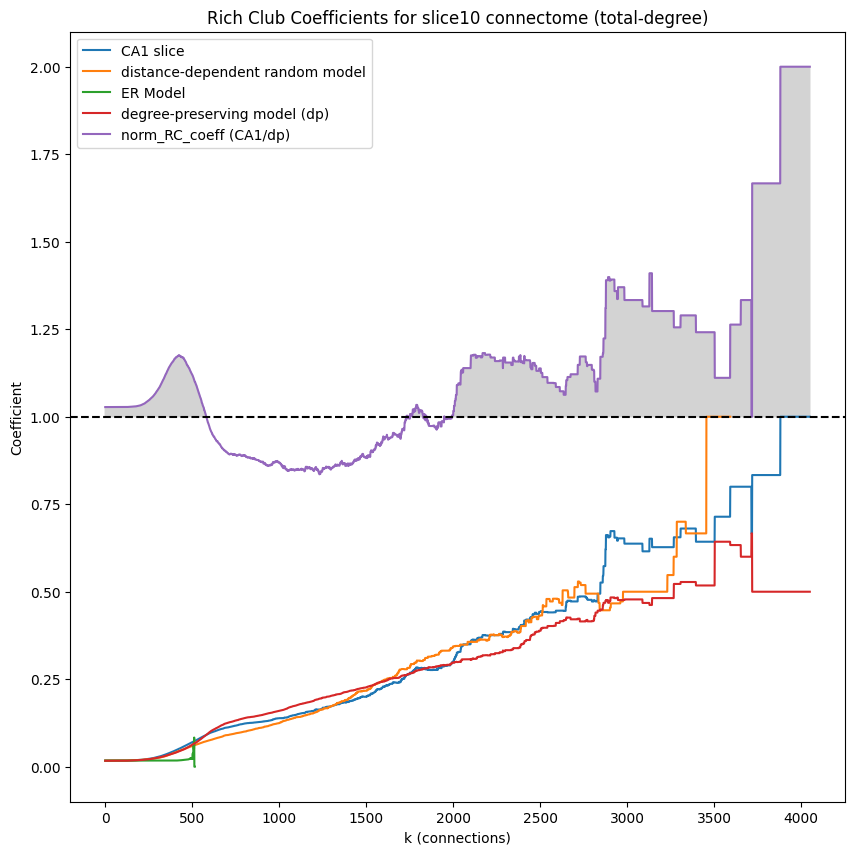

In [243]:
f ,ax= plt.subplots(figsize=(10,10))

plt.plot(k_dict_parallel_model.keys(),k_dict_parallel_model.values())
plt.plot(k_dict_parallel_dd.keys(),k_dict_parallel_dd.values())
plt.plot(k_dict_parallel_er.keys(),k_dict_parallel_er.values())
plt.plot(k_dict_parallel_dp.keys(),k_dict_parallel_dp.values())

norm_rc = np.array(list(k_dict_parallel_model.values())) / np.array(list(k_dict_parallel_dp.values()))
plt.plot(k_dict_parallel_model.keys(),norm_rc)
ax.axhline(y=1, color='k', linestyle='--', label='y=1')
ax.fill_between(k_dict_parallel_model.keys(), norm_rc, 1, where=(np.array(norm_rc) >= 1), color='lightgray')

plt.title('Rich Club Coefficients for slice10 connectome (total-degree)')
plt.xlabel('k (connections)')
plt.ylabel('Coefficient')
plt.legend(['CA1 slice',
            'distance-dependent random model',
            'ER Model',
            'degree-preserving model (dp)',
            'norm_RC_coeff (CA1/dp)'])
plt.savefig(f"../output/rich_club_directed_totdegree.png", dpi=dpi, bbox_inches='tight')

In [264]:
orig_values[:random_values.shape[0]].shape

(4071,)

In [277]:
len(k_dict_parallel_dd.keys())

4071

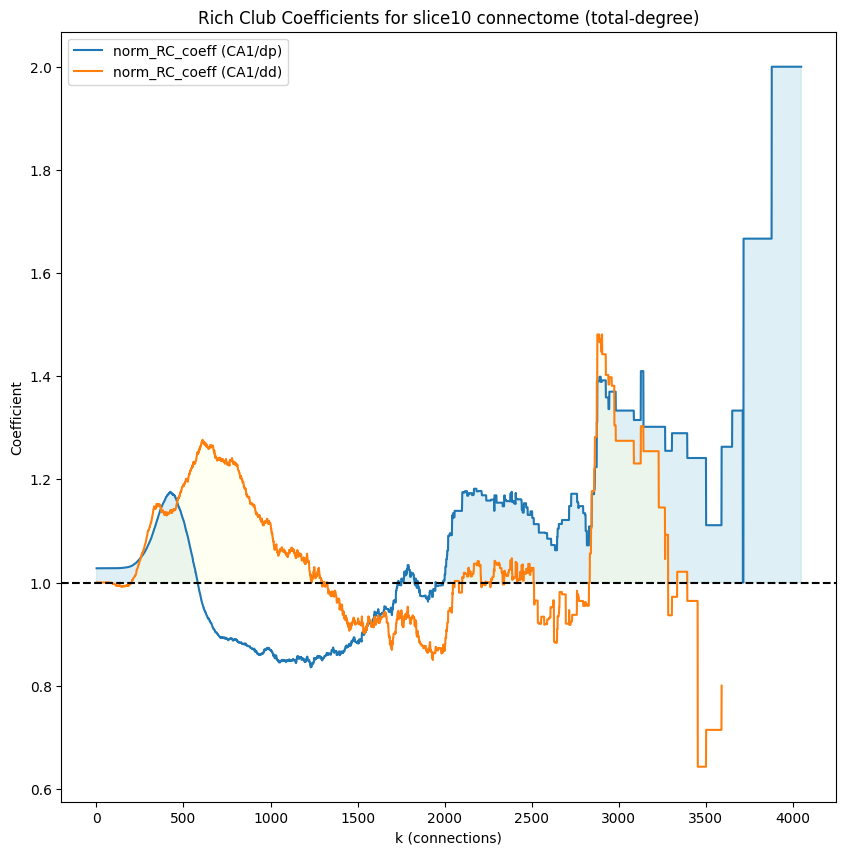

In [276]:
f ,ax= plt.subplots(figsize=(10,10))

norm_rc_dp = np.array(list(k_dict_parallel_model.values())) / np.array(list(k_dict_parallel_dp.values()))
plt.plot(k_dict_parallel_model.keys(),norm_rc_dp)

orig_values = np.array(list(k_dict_parallel_model.values()))
random_values = np.array(list(k_dict_parallel_dd.values()))
norm_rc = orig_values[:random_values.shape[0]] / random_values
plt.plot(k_dict_parallel_dd.keys(),norm_rc)

ax.fill_between(k_dict_parallel_model.keys(), norm_rc_dp, 1, where=(np.array(norm_rc_dp) >= 1), color='lightblue',alpha=0.4)
ax.fill_between(k_dict_parallel_dd.keys(), norm_rc, 1, where=(np.array(norm_rc) >= 1), color='lightyellow',alpha=0.4)
ax.axhline(y=1, color='k', linestyle='--', label='y=1')


plt.title('Rich Club Coefficients for slice10 connectome (total-degree)')
plt.xlabel('k (connections)')
plt.ylabel('Coefficient')
plt.legend(['norm_RC_coeff (CA1/dp)', 'norm_RC_coeff (CA1/dd)'])
# plt.savefig(f"../output/rich_club_directed_totdegree.png", dpi=dpi, bbox_inches='tight')

In [ ]:
# rc for indegree for synaptome 
rca = RichClubAnalysis(target_connectome)
# Example usage

# Start Dask client
client = Client()

k_dict_parallel_model = rca.calculate_rich_club_coefficients(indegrees)
k_dict_parallel_dd = rca_dd.calculate_rich_club_coefficients(indegrees_dd)
k_dict_parallel_er = rca_er.calculate_rich_club_coefficients(indegree_er)

# Shutdown the Dask client
client.shutdown()



plt.plot(k_dict_parallel_model.keys(),k_dict_parallel_model.values())
plt.plot(k_dict_parallel_dd.keys(),k_dict_parallel_dd.values())
plt.plot(k_dict_parallel_er.keys(),k_dict_parallel_er.values())

plt.title('Rich Club Coefficients for slice10 connectome')
plt.xlabel('k')
plt.ylabel('Coefficient')
plt.legend(['CA1 slice','distance-dependent random model','ER Model'])
plt.savefig(f"../output/rich_club_directed_indegree.png", dpi=dpi, bbox_inches='tight')


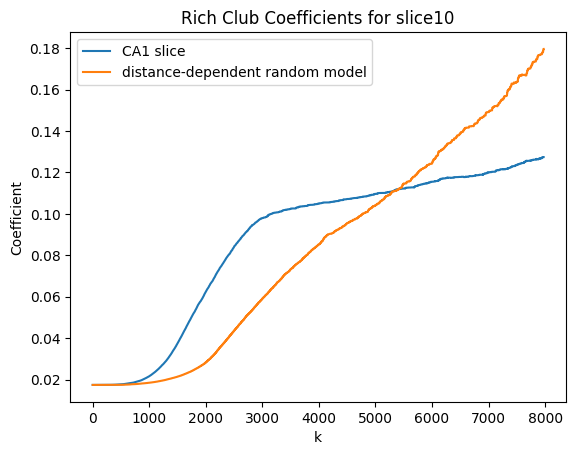

In [41]:
plt.plot(k_dict_parallel_model.keys(),k_dict_parallel_model.values())
plt.plot(k_dict_parallel_dd.keys(),k_dict_parallel_dd.values())

plt.title('Rich Club Coefficients for slice10')
plt.xlabel('k')
plt.ylabel('Coefficient')
plt.legend(['CA1 slice','distance-dependent random model'])
plt.savefig(f"../output/rich_club_directed_indegree.png", dpi=dpi, bbox_inches='tight')